$\def \dot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \adot #1#2{\left\langle #1, #2 \right\rangle}$
$\def \cA {\mathcal{A}}$
$\def \cD {\mathcal{D}}$
$\def \cM {\mathcal{M}}$
$\def \cN {\mathcal{N}}$
$\def \cW {\mathcal{W}}$
$\def \bc {\mathbf{c}}$
$\def \bu {\mathbf{u}}$
$\def \bv {\mathbf{v}}$
$\def \bw {\mathbf{w}}$
$\def \bx {\mathbf{x}}$
$\def \by {\mathbf{y}}$
$\def \bG {\mathbf{G}}$
$\def \bC {\mathbf{C}}$
$\def \bD {\mathbf{D}}$
$\def \bI {\mathbf{I}}$
$\def \bP {\mathbf{P}}$
$\def \bQ {\mathbf{Q}}$
$\def \bR {\mathbf{R}}$
$\def \bS {\mathbf{S}}$
$\def \bT {\mathbf{T}}$
$\def \bU {\mathbf{U}}$
$\def \bV {\mathbf{V}}$
$\def \bW {\mathbf{W}}$
$\def \bPhi {\mathbf{\Phi}}$
$\def \bPsi {\mathbf{\Psi}}$
$\def \bGamma {\mathbf{\Gamma}}$
$\def \bSigma {\mathbf{\Sigma}}$
$\def \bTheta {\mathbf{\Theta}}$
$\def \bOmega {\mathbf{\Omega}}$
$\def \bbE {\mathbb{E}}$
$\def \bbP {\mathbb{P}}$
$\def \bbR {\mathbb{R}}$
$\def \bbN {\mathbb{N}}$

# Now let us consider the PDE problem 

We compute $N$ snapshots, we truncate the PCA at some $n$, and we compare the PCA computed using the "outer" and "inner" product of the snapshot basis.

In [35]:
import numpy as np
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
import pdb
from IPython.display import Latex, display

import sys
sys.path.append("../../")
import pyApproxTools as pat
importlib.reload(pat)

%matplotlib inline

# Constants taken throughout this workbook
fem_div = 6
a_bar = 1.0
c = 0.9
field_div = 2
side_n = 2**field_div

def make_soln(points, fem_div, a_bar=1.0, c=0.5, f=1.0, verbose=False):
    
    solns = []
    fields = []

    for p in points:
        field = pat.PWConstantSqDyadicL2(a_bar + c * p.reshape((2,2)))
        fields.append(field)
        # Then the fem solver (there a faster way to do this all at once? This will be huge...
        fem_solver = pat.DyadicFEMSolver(div=fem_div, rand_field = field, f = 1)
        fem_solver.solve()
        solns.append(fem_solver.u)
        
    return solns, fields

Once again we define the operators $U :\bbR^N\to V$ as $U \bx = \sum_{i=1}^N \bx_i u_i$ and evidently $U^* v = (\langle u_i, v \rangle_V )_{i=1}^N$.

We consider $C = U U^*$ and $\bG = U^* U$. It is straightforward to see that $(\bG)_{i,j} = \langle u_i, u_j \rangle$. Since they are both Hermitian positive-definite operators

$$
C =  U U^* = \Phi \bSigma \bSigma^T \Phi^T \quad\text{and}\quad \bG = U^* U = \bTheta \bSigma^T \bSigma \bTheta^T
$$

where the operator $\Phi \bx = \sum_{i=1}^N \varphi_i \bx_i$ and the $\varphi_i\in V$ are orthonormal, $\bTheta$ is a matrix with orthonormal columns, and $\bSigma = \mathrm{diag}(\sigma_1,\ldots,\sigma_N)$. In fact, these come from $U$ which will have some Hilbert-Schmidt decomposition

$$
U = \Phi \bSigma \bTheta^T
$$

Note that $\bSigma \bSigma^T$ is a diagonal $K\times K$ matrix, while $\bSigma^T \bSigma$ is $N\times N$, they both are diagonal with $\sigma_i^2$ along the diagonal.

Our goal is to find the $\varphi_i$. There are two ways - through $C$, and through $\bG$.

Using $\bTheta$ found from $\bG$, we have that $\Phi = U \bTheta \bSigma^{-1}$, i.e. that 

$$
\varphi_j = \sum_i \frac{\bTheta_{i,j} u_i}{\sigma_i}
$$

Using $C$ we first need some orthonormal basis of $V$, say $\psi_1,\ldots,\psi_K$ (that is assume $V$ is $K$ dimensional for now), then we can write $u_j$ in terms of $\psi_i$, and in fact let

$$
\bU_{i,j} = \langle \psi_i, u_j \rangle
$$

then using similar notation to before we have that $U = \Psi \bU$, and 

$$
C = U U^* = \Psi \bU \bU^T \Psi^* 
$$

In the experiments below we find that $\bU \bU^T = \bPhi \bSigma \bSigma^T \bPhi^T$ where $\bPhi_{i,j} = \langle \psi_i, \varphi_j \rangle$, with $\varphi_j$ and $\bSigma$ exactly as before. Then at last we have that 

$$
\varphi_i = \sum_{j=1}^K \bPhi_{i,j} \psi_j
$$

and indeed this $\varphi_i$ is shown to be the same as the previous one in the following experiments


(note: Say that $V_n = \mathrm{span}(u_1,\ldots,u_N)$, clearly $n\le N$. Now, $v = P_{V_n} v + P_{V_n^\perp}v$, and obviously $U^* P_{V_n^\perp} = 0$)

### The $\bG$ approach

Below we derive the $\varphi_i$ which are contained in ```PCA_Basis_1```

In [55]:
N = 1000
eig_tol = 1e-12

points = np.random.random((N, side_n)) * 2 - 1

us, fields = make_soln(points, fem_div, a_bar, c)
U = pat.PWBasis(us)

sig_1, V_1 = sp.linalg.eigh(U.G)

V_1 = V_1[:,::-1]
sig_1 = sig_1[::-1]
V_1 = V_1[:,sig_1 > eig_tol]
sig_1 = sig_1[sig_1 > eig_tol]

PCA_Basis_1 = U @ V_1 @ np.diag(np.sqrt(1.0/sig_1))

### Now generate an orthonormal basis $\psi_j$ based on multi-level hat functions

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

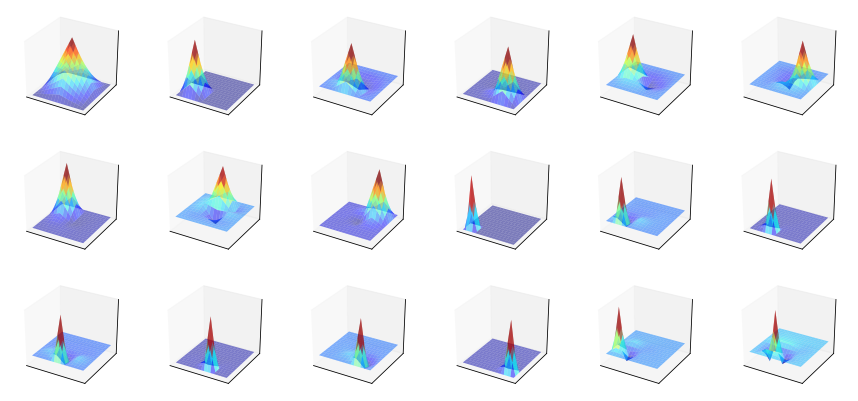

In [152]:
Psi_vecs = []
taken = np.zeros((2**fem_div-1, 2**fem_div-1), dtype=np.bool)

for small_d in range(1,fem_div+1):
    for i in range(2**small_d - 1):
        for j in range(2**small_d - 1):
            vals = np.zeros((2**small_d+1, 2**small_d+1))
            vals[i+1, j+1] = 1

            if not taken[(i+1) * 2**(fem_div - small_d) - 1, (j+1) * 2**(fem_div - small_d) - 1]:
                Psi_vecs.append(pat.PWLinearSqDyadicH1(values=vals, div=small_d).interpolate(fem_div))
                taken[(i+1) * 2**(fem_div - small_d) - 1, (j+1) * 2**(fem_div - small_d) - 1] = True
            
Psi = pat.PWBasis(Psi_vecs)
display(Latex(r'Condition number of $\Psi$ basis before orthonormalising: {0}'.format(np.linalg.cond(Psi.G))))
Psi = Psi.orthonormalise()

display(Latex(r'Plots of first 18 orthonormalised hat functions:'))
fig = plt.figure(figsize=(15, 7))
for i, v in enumerate(Psi[:18]):
    ax = fig.add_subplot(3, 6, i+1, projection='3d')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    ax.zaxis.set_ticks([])
    v.plot(ax, show_axes_labels=False)

plt.show()

### Now the $C$ approach

The resulting $\varphi_i$ are in ```PCA_Basis_2```

In [57]:
U_basis = Psi.H @ U

C = U_basis @ U_basis.T

sig_2, V_2 = sp.linalg.eigh(C)

V_2 = V_2[:,::-1]
sig_2 = sig_2[::-1]
V_2 = V_2[:,sig_2 > eig_tol]
sig_2 = sig_2[sig_2 > eig_tol]

PCA_Basis_2 = Psi @ V_2

In [133]:
print('length of PCA basis 1: {0}, and PCA Basis 2: {1}'.format(PCA_Basis_1.n, PCA_Basis_2.n))
display(Latex(r'$\sigma_i$ calculated using $\bG = U^* U$:'))
print(sig_1)
display(Latex(r'$\sigma_i$ calculated using $C = U U^*$:'))
print(sig_2)
(PCA_Basis_1[0] - PCA_Basis_2[0]).norm()

display(Latex(r'Comparison of $\varphi_i$ calculated using $\bG$ (labelled $\varphi_i^{(1)}$) and $C$ (labelled $\varphi_i^{(2)}$)'))

table_string = r'\begin{array}{c c c c} \hline \
                 i & \
                 \langle \varphi_{{{0}}}^{{(1)}}, \varphi_{{{0}}}^{{(2)}} \rangle & \
                 \| \varphi_{{{0}}}^{{(1)}} - \varphi_{{{0}}}^{{(2)}} \| & \
                 \sigma_{{{0}}} \\ \hline'
for i, (v1, v2) in enumerate(zip(PCA_Basis_1, PCA_Basis_2)):
    table_string += r'{0} & \mathtt{{{1:.3e}}} & \mathtt{{{2:.3e}}} & \mathtt{{{3:.3e}}} \\'.format(i, v1.dot(v2), (v1-v2).norm(), sig_1[i])
table_string += r'\hline \end{array}'
display(Latex(table_string))

length of PCA basis 1: 20, and PCA Basis 2: 20


<IPython.core.display.Latex object>

[4.15187775e+00 4.46156535e-01 3.92347862e-01 3.67072062e-01
 7.43083597e-02 3.70648334e-02 3.56986074e-02 2.83674420e-02
 4.05217294e-03 2.72475083e-04 2.23931766e-04 4.75858074e-05
 2.79631928e-06 4.84553421e-07 4.35572153e-07 8.71692700e-08
 1.71624792e-10 1.43201178e-10 9.33517728e-11 4.87860746e-11]


<IPython.core.display.Latex object>

[4.15187775e+00 4.46156535e-01 3.92347862e-01 3.67072062e-01
 7.43083597e-02 3.70648334e-02 3.56986074e-02 2.83674420e-02
 4.05217294e-03 2.72475083e-04 2.23931766e-04 4.75858074e-05
 2.79631928e-06 4.84553421e-07 4.35572153e-07 8.71692701e-08
 1.71624770e-10 1.43201188e-10 9.33518121e-11 4.87860348e-11]


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### Plot the first 4 eigen-functions (to make sure they're not crazy...)

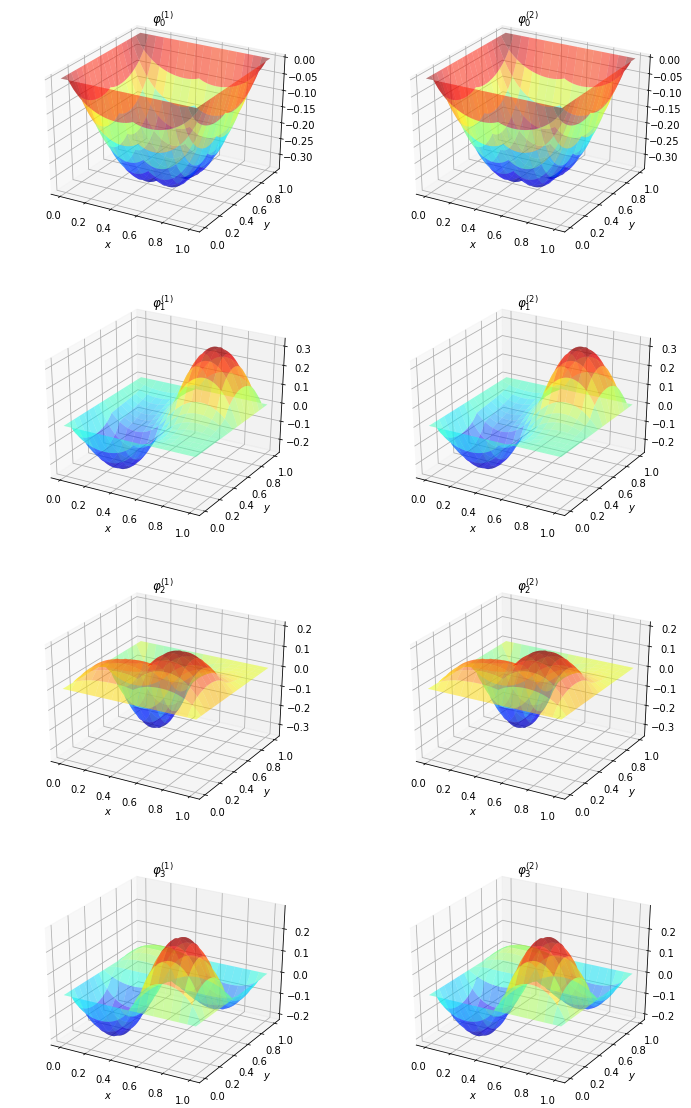

In [134]:
fig = plt.figure(figsize=(12, 20))
for i, (v1, v2) in enumerate(zip(PCA_Basis_1[:4], PCA_Basis_2[:4])):
    ax = fig.add_subplot(4, 2, 2*i+1, projection='3d')
    v1.plot(ax)
    ax.set_title(r'$\varphi_{{{0}}}^{{(1)}}$'.format(i))
    ax = fig.add_subplot(4, 2, 2*i+2, projection='3d')
    v2.plot(ax)
    ax.set_title(r'$\varphi_{{{0}}}^{{(2)}}$'.format(i))
plt.show()